# Naive Bayes Binary Classifier - SOLUTIONS

In this practical, we will build a Naive Bayes classifier from scratch for binary classification on the Iris dataset.

In [1]:
from sklearn.metrics import accuracy_score
from sklearn import datasets, model_selection
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.rcParams['figure.figsize'] = (10, 6)

## Load and Prepare the Iris Dataset

We will use only the first two features (sepal length and width) and convert the problem to binary classification:
- Class 0: Iris-Setosa
- Class 1: Iris-Versicolour and Iris-Virginica (combined)

In [2]:
# Load the Iris dataset
iris = datasets.load_iris()
data = iris.data[:, :2]  # Only sepal length and width
targets = iris.target

# Convert to binary classification
targets_binary = np.where(targets == 0, 0, 1)

# Split into train and test sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    data, targets_binary, test_size=0.2, random_state=42
)

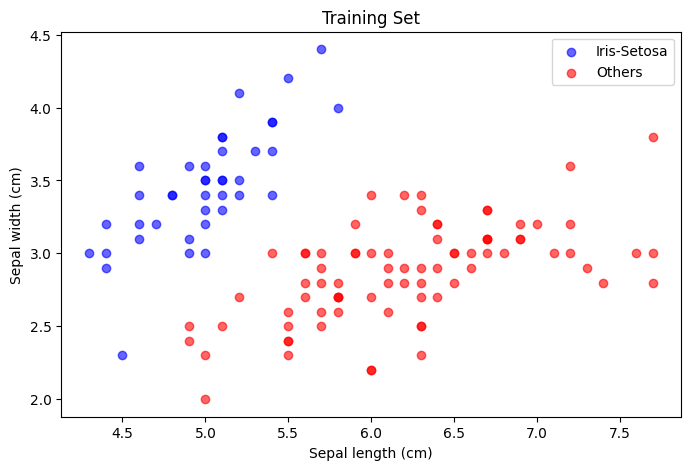

In [3]:
# Visualize the training data
labels = {0: 'Iris-Setosa', 1: 'Others'}
colors = ['blue', 'red']

plt.figure(figsize=(8, 5))
for c in [0, 1]:
    mask = y_train == c
    plt.scatter(x_train[mask, 0], x_train[mask, 1], 
                label=labels[c], c=colors[c], alpha=0.6)

plt.xlabel("Sepal length (cm)")
plt.ylabel("Sepal width (cm)")
plt.title("Training Set")
plt.legend()
plt.show()

## Naive Bayes Theory

The Naive Bayes classifier uses Bayes' rule:

$$P(Y=k | X_1, X_2) = \frac{P(X_1, X_2 | Y=k) \cdot P(Y=k)}{P(X_1, X_2)}$$

The "naive" assumption is that features are independent given the class:

$$P(X_1, X_2 | Y=k) = P(X_1 | Y=k) \cdot P(X_2 | Y=k)$$

For prediction, we choose the class with maximum posterior probability:

$$\hat{Y} = \arg\max_k P(Y=k | X_1, X_2) \propto P(X_1 | Y=k) \cdot P(X_2 | Y=k) \cdot P(Y=k)$$

## Exercise 1: Compute the Class Prior

The prior probability is simply the proportion of samples in each class:

$$P(Y=k) = \frac{\text{number of samples in class } k}{\text{total number of samples}}$$

In [4]:
def compute_prior(y):
    """
    Compute prior probabilities P(Y=k) for each class.
    
    Args:
        y: array of labels, shape (n_samples,)
    
    Returns:
        priors: array of prior probabilities, shape (n_classes,)
    """
    # Count occurrences of each class
    unique_classes, counts = np.unique(y, return_counts=True)
    
    # Compute proportions
    priors = counts / len(y)
    
    return priors

Prior probabilities: [0.33333333 0.66666667]
P(Setosa) = 0.333
P(Others) = 0.667


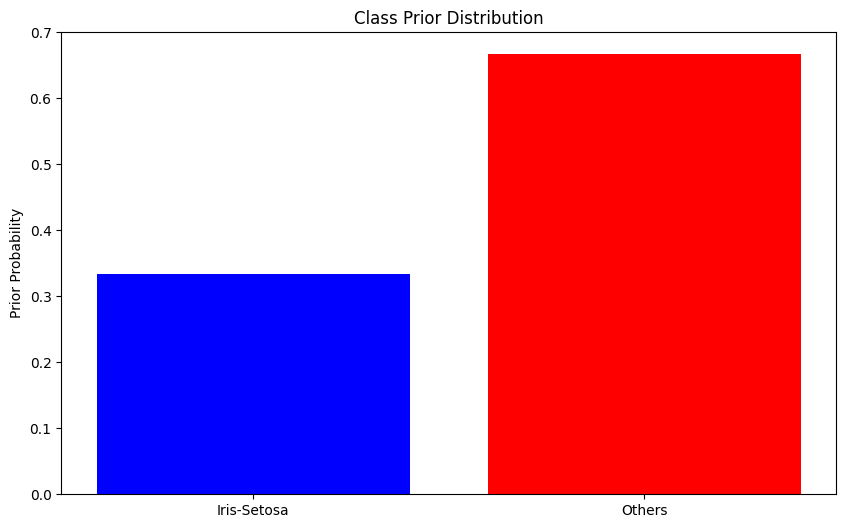

In [5]:
# Test your function
priors = compute_prior(y_train)
print(f"Prior probabilities: {priors}")
print(f"P(Setosa) = {priors[0]:.3f}")
print(f"P(Others) = {priors[1]:.3f}")

# Visualize
plt.bar([0, 1], priors, color=colors)
plt.xticks([0, 1], labels.values())
plt.ylabel("Prior Probability")
plt.title("Class Prior Distribution")
plt.show()

## Exercise 2: Compute Class-Conditional Parameters

We assume each feature follows a Gaussian distribution for each class:

$$P(X_i | Y=k) = \mathcal{N}(\mu_{ik}, \sigma_{ik}^2)$$

We estimate these parameters using maximum likelihood:

$$\mu_{ik} = \frac{1}{n_k} \sum_{j: y_j=k} x_{ij}$$

$$\sigma_{ik}^2 = \frac{1}{n_k} \sum_{j: y_j=k} (x_{ij} - \mu_{ik})^2$$

In [6]:
def compute_gaussian_params(x, y):
    """
    Compute mean and std for each feature in each class.
    
    Args:
        x: array of features, shape (n_samples, n_features)
        y: array of labels, shape (n_samples,)
    
    Returns:
        means: array of means, shape (n_classes, n_features)
        stds: array of standard deviations, shape (n_classes, n_features)
    """
    n_classes = len(np.unique(y))
    n_features = x.shape[1]
    
    means = np.zeros((n_classes, n_features))
    stds = np.zeros((n_classes, n_features))
    
    for k in range(n_classes):
        # Get samples belonging to class k
        x_k = x[y == k]
        
        # Compute mean and std for each feature
        means[k] = np.mean(x_k, axis=0)
        stds[k] = np.std(x_k, axis=0)
    
    return means, stds

In [7]:
# Test your function
means, stds = compute_gaussian_params(x_train, y_train)

print("Class-conditional parameters:")
print(f"\nClass 0 (Setosa):")
print(f"  Feature 0: mean={means[0,0]:.3f}, std={stds[0,0]:.3f}")
print(f"  Feature 1: mean={means[0,1]:.3f}, std={stds[0,1]:.3f}")
print(f"\nClass 1 (Others):")
print(f"  Feature 0: mean={means[1,0]:.3f}, std={stds[1,0]:.3f}")
print(f"  Feature 1: mean={means[1,1]:.3f}, std={stds[1,1]:.3f}")

Class-conditional parameters:

Class 0 (Setosa):
  Feature 0: mean=4.990, std=0.352
  Feature 1: mean=3.452, std=0.391

Class 1 (Others):
  Feature 0: mean=6.219, std=0.667
  Feature 1: mean=2.866, std=0.331


## Exercise 3: Implement the Prediction Function

To make predictions, we compute the log posterior for each class:

$$\log P(Y=k | X) \propto \log P(Y=k) + \sum_{i=1}^2 \log P(X_i | Y=k)$$

We use log probabilities for numerical stability.

In [8]:
def predict_naive_bayes(x, priors, means, stds):
    """
    Predict class labels using Naive Bayes.
    
    Args:
        x: array of features, shape (n_samples, n_features)
        priors: prior probabilities, shape (n_classes,)
        means: class means, shape (n_classes, n_features)
        stds: class stds, shape (n_classes, n_features)
    
    Returns:
        predictions: array of predicted labels, shape (n_samples,)
    """
    n_samples = x.shape[0]
    n_classes = len(priors)
    n_features = x.shape[1]
    
    # Initialize log posteriors
    log_posteriors = np.zeros((n_samples, n_classes))
    
    for k in range(n_classes):
        # Start with log prior
        log_posteriors[:, k] = np.log(priors[k])
        
        # Add log likelihood for each feature
        for j in range(n_features):
            log_posteriors[:, k] += norm.logpdf(x[:, j], means[k, j], stds[k, j])
    
    # Return class with maximum log posterior
    predictions = np.argmax(log_posteriors, axis=1)
    
    return predictions

In [9]:
# Test your prediction function
predictions = predict_naive_bayes(x_test, priors, means, stds)

accuracy = accuracy_score(y_test, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 1.0000


## Visualize Decision Boundary

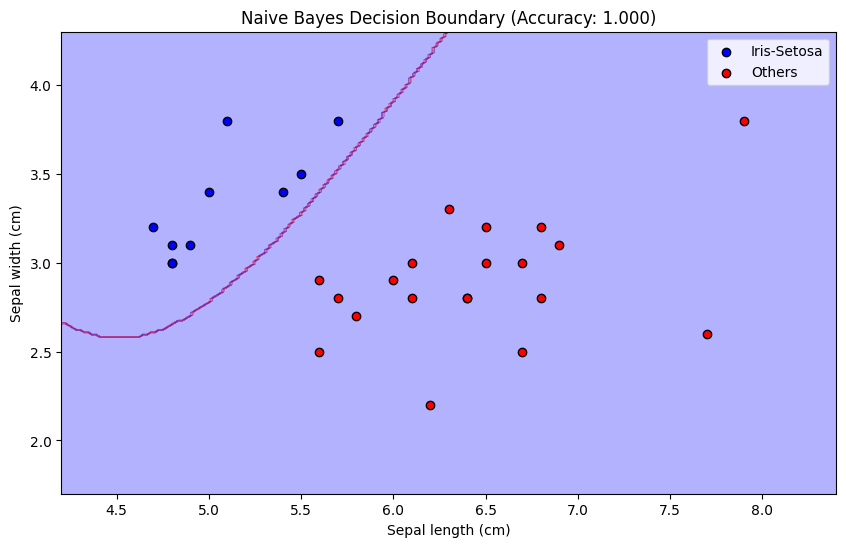

In [10]:
# Create a mesh to plot decision boundary
x0_min, x0_max = x_test[:, 0].min() - 0.5, x_test[:, 0].max() + 0.5
x1_min, x1_max = x_test[:, 1].min() - 0.5, x_test[:, 1].max() + 0.5
xx0, xx1 = np.meshgrid(np.linspace(x0_min, x0_max, 200),
                        np.linspace(x1_min, x1_max, 200))

# Predict for all points in the mesh
mesh_points = np.c_[xx0.ravel(), xx1.ravel()]
Z = predict_naive_bayes(mesh_points, priors, means, stds)
Z = Z.reshape(xx0.shape)

# Plot
plt.figure(figsize=(10, 6))
plt.contourf(xx0, xx1, Z, alpha=0.3, colors=colors)

for c in [0, 1]:
    mask = y_test == c
    plt.scatter(x_test[mask, 0], x_test[mask, 1], 
                label=labels[c], c=colors[c], edgecolor='k')

plt.xlabel("Sepal length (cm)")
plt.ylabel("Sepal width (cm)")
plt.title(f"Naive Bayes Decision Boundary (Accuracy: {accuracy:.3f})")
plt.legend()
plt.show()

## Compare with sklearn's Implementation

In [11]:
from sklearn.naive_bayes import GaussianNB

# Train sklearn's Naive Bayes
sklearn_nb = GaussianNB()
sklearn_nb.fit(x_train, y_train)
sklearn_pred = sklearn_nb.predict(x_test)
sklearn_accuracy = accuracy_score(y_test, sklearn_pred)

print(f"Your implementation accuracy: {accuracy:.4f}")
print(f"Sklearn implementation accuracy: {sklearn_accuracy:.4f}")
print(f"\nDifference: {abs(accuracy - sklearn_accuracy):.4f}")

Your implementation accuracy: 1.0000
Sklearn implementation accuracy: 1.0000

Difference: 0.0000


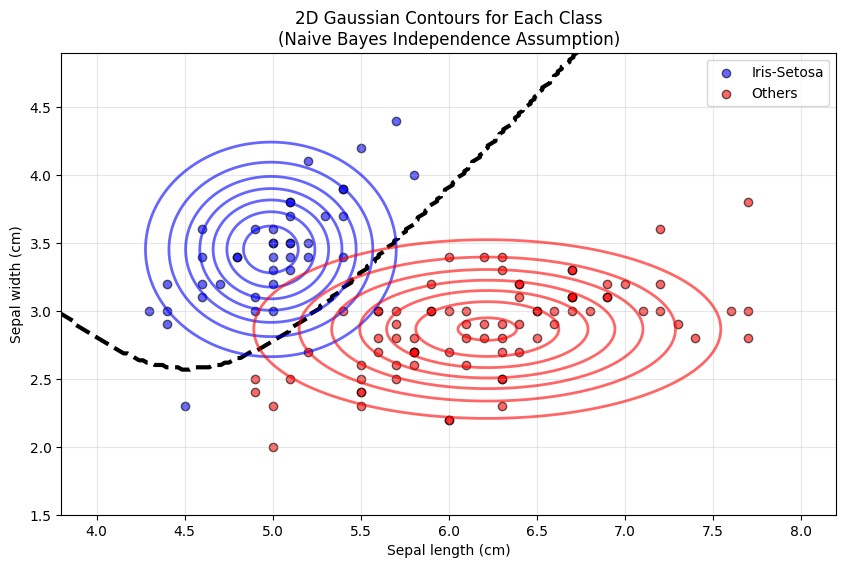

In [12]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have: x_train, y_train, means, stds, labels, colors

plt.figure(figsize=(10, 6))

# Plot training data points
for c in [0, 1]:
    mask = y_train == c
    plt.scatter(x_train[mask, 0], x_train[mask, 1], 
                label=labels[c], c=colors[c], alpha=0.6, edgecolor='k')

# Create mesh grid for contour plot
x0_min, x0_max = x_train[:, 0].min() - 0.5, x_train[:, 0].max() + 0.5
x1_min, x1_max = x_train[:, 1].min() - 0.5, x_train[:, 1].max() + 0.5
xx0, xx1 = np.meshgrid(np.linspace(x0_min, x0_max, 200),
                        np.linspace(x1_min, x1_max, 200))
mesh_points = np.c_[xx0.ravel(), xx1.ravel()]

# Compute predictions on the mesh
Z_pred = predict_naive_bayes(mesh_points, priors, means, stds)
Z_pred = Z_pred.reshape(xx0.shape)

# Plot the boundary at level 0.5 (between classes 0 and 1)
plt.contour(xx0, xx1, Z_pred, levels=[0.5], colors='black', 
            linewidths=3, linestyles='--')

# Plot contours for each class
for k in range(2):
    # Create diagonal covariance matrix (Naive Bayes independence assumption)
    cov = np.diag(stds[k]**2)
    
    # Create multivariate normal distribution
    mvn = multivariate_normal(mean=means[k], cov=cov)
    
    # Evaluate probability density on mesh
    Z = mvn.pdf(mesh_points).reshape(xx0.shape)
    
    # Plot contours
    plt.contour(xx0, xx1, Z, colors=colors[k], alpha=0.6, linewidths=2)

plt.xlabel("Sepal length (cm)")
plt.ylabel("Sepal width (cm)")
plt.title("2D Gaussian Contours for Each Class\n(Naive Bayes Independence Assumption)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()